### Notebook for testing functions in pyAT ###

In [1]:
import at
import pickle
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy.stats import truncnorm
import utils

def rms(A):
    return np.sqrt(np.nanmean(A**2,axis=0))


In [2]:
# latticeFile = './lattices/AS2v225_converted'
# latticeFile = './lattices/seed01_pyAT'
latticeFile = './matlab/seeds/seed1_preCorrection_pyAT'
with open(latticeFile,'rb') as fid:
    ring0 = pickle.load(fid)

latticeFile = './matlab/seeds/seed1_postCorrection_pyAT'
with open(latticeFile,'rb') as fid:
    ring1 = pickle.load(fid)


In [3]:
HCM = utils.getCorrectorStrengths(ring1,'x')
VCM = utils.getCorrectorStrengths(ring1,'y')

newRing = deepcopy(ring0)
newRing = utils.setCorrectorStrengths(newRing,'x',HCM)
newRing = utils.setCorrectorStrengths(newRing,'y',VCM)

[B0,T0]  = utils.getBPMreading(ring0)
[B1,T1]  = utils.getBPMreading(ring1)
[Bnew,Tnew]  = utils.getBPMreading(newRing)

In [4]:
print(rms(B0))
print(rms(B1))
print(rms(Bnew))

[0.0005449  0.00107367]
[6.37502985e-06 4.63840676e-06]
[6.37502993e-06 4.63840677e-06]


In [7]:
chv = ring1.get_uint32_index(at.Corrector)
print(ring0[chv[0]])

sf = ring1.get_bool_index("SF*")
sf = np.where(sf)[0]
# print(ring1[sf[0]])

Corrector:
       FamName: COR1
        Length: 0.0
    PassMethod: CorrectorPass
       CMlimit: array('d', [inf, inf])
     CalErrorA: 0.0
     CalErrorB: 0.0
     KickAngle: [0. 0.]
  MagnetOffset: array('d', [0.0, -0.0, 0.0])
    MagnetRoll: array('d', [0.0, -0.0, -0.0])
      MaxOrder: 0
   NomPolynomA: 0.0
   NomPolynomB: 0.0
      PolynomA: [0.]
PolynomAOffset: 0.0
      PolynomB: [0.]
PolynomBOffset: 0.0
            R1: [[ 9.99999998e-01  0.00000000e+00  7.00124350e-05  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.99999998e-01  0.00000000e+00  7.00124350e-05
   0.00000000e+00  0.00000000e+00]
 [-7.00124350e-05 -0.00000000e+00  9.99999998e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.00124350e-05  0.00000000e+00  9.99999998e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+

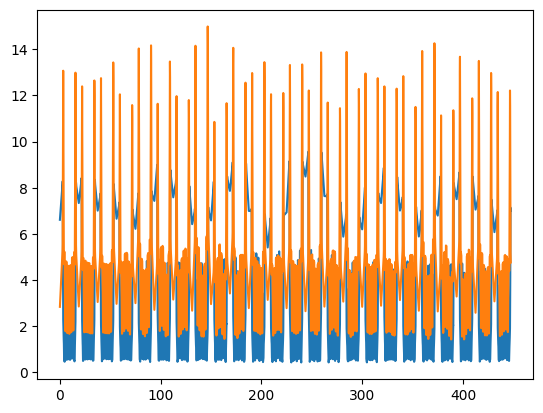

In [4]:
# bpm = ring.get_uint32_index(at.Monitor)
ords = range(len(ring))
[ed0,rd,ed] = at.get_optics(ring,ords)
CO = ed.closed_orbit
rms(CO[:,0])
plt.plot(ed.s_pos,ed.beta)

In [ ]:
rms(CO[:,0])

3.5066895149741284e-05

In [ ]:
def checkClosedOrbitExists(ring):
    T = at.find_orbit6(ring)
    return ~np.any(np.isnan(T[0]))
    

def getBPMreading(ring,makePlot=0):
    """ get BPM reading from tracking and add measurement errors

    Args:
        ring (lattice array): lattice array
        makePlot (int, optional): flag for plotting BPM readings. Defaults to 0.

    Returns:
        B (len(bpm),2): stacked array for BPM reading in x and y with errors
        T (len(ring),2): stacked array for relative position between beam trajectory and element centre
    """
    closedOrbitExists = checkClosedOrbitExists(ring)

    bpm = ring.get_uint32_index(at.Monitor)
    if ~closedOrbitExists:
        # track in single shot mode
        #
        nTurns = 1
        nShots = 10
        sigCutoff = 2
        injectionError = [1e-4, 1e-5, 1e-4, 1e-5, 1e-4, 1e-4] # [m, rad, m, rad, rel., m]

        Zin = np.zeros((6,nShots))
        for n,error in enumerate(injectionError):
            generator = truncnorm(-sigCutoff,sigCutoff,loc=0,scale=error)
            Zin[n,:] = generator.rvs(nShots)

        # Zout: [6 x Nshots x refpts x nTurns]
        #
        [Zout,trackParam,trackData] = ring.track(Zin,nTurns,refpts=range(len(ring)),losses=1)
        
        # at.track only changes x coord to nan if particle is lost
        # change all coords to nan for lost particles
        #
        IsNan = np.isnan(Zout)
        Zout[:,IsNan[0,:,:,0],:] = np.nan

        # average over all shots and transpose to get to same shape as closed orbit mode
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        # Do we want this nanmean here? This will bias bpm readings to shots that have small deviation
        # and ignore shots that have particle losses
        #
        T = np.nanmean(Zout[:,:,:,0],axis=1).T
        # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        #
    else:
        # closed orbit mode
        #
        T = at.find_orbit6(ring,range(len(ring)))
        T = T[1]

    # calculate relative different between beam trajectory and element centre
    # adding in element offset and roll errors
    #
    offset = np.zeros((len(ring),2))
    roll = np.zeros(len(ring))

    for n,ele in enumerate(ring):
        if hasattr(ele,'Offset'):
            offset[n,:] = np.array(ele.Offset) + np.array(ele.SupportOffset)

        if hasattr(ele,'Roll'):
            roll[n] = ele.Roll + ele.SupportRoll

    # only need x,y coords
    #
    T = T[:,[0,2]]

    # add offset and roll error
    #
    T[:,0] = np.cos(roll) * T[:,0] - np.sin(roll) * T[:,1]
    T[:,1] = np.sin(roll) * T[:,0] + np.cos(roll) * T[:,1]
    T = T - offset

    # calculate effects on BPM reading due to BPM errors
    # NOT INCLUDED: TbT noise
    #
    BPMcalError = np.array([ele.CalError for ele in ring[bpm]])
    BPMnoise    = np.array([ele.NoiseCO for ele in ring[bpm]])

    # add BPM calibration error and noise
    #
    B = T[bpm,:]
    B = B * (1 + BPMcalError)
    B = B + BPMnoise

    if makePlot:
        spos = at.get_s_pos(ring,range(len(ring)))
        fig = plt.figure()
        gs = fig.add_gridspec(2,hspace=0)
        axs = gs.subplots(sharex=True)

        axs[0].plot(spos[bpm],B[:,0]*1e6)
        axs[0].plot(spos,T[:,0]*1e6)
        axs[0].set_ylabel(f'x [$\mu$m]')
        axs[0].grid()

        axs[1].plot(spos[bpm],B[:,1]*1e6)
        axs[1].plot(spos,T[:,1]*1e6)
        axs[1].set_ylabel(f'y [$\mu$m]')
        axs[1].grid()

        plt.xlabel('s [m]')
        plt.legend(['BPMs','All eles'])
        plt.tight_layout()

    return B,T

In [163]:
[B,T] = getBPMreading(ring)

In [167]:
C = np.concatenate(B)
C.shape

(720,)

In [6]:
bpm = ring.get_uint32_index(at.Monitor)
chv = ring.get_uint32_index(at.Corrector)
SX = ring.get_uint32_index(at.Sextupole)
# co = getBPMreading(ring)
# print(ring[chv[0]])
offsets = at.get_value_refpts(ring,SX,'PolynomB')
bpm.shape

(360,)

In [7]:
# combined hori. and ver. fast correctors
#
chv = ring.get_uint32_index(at.Corrector)

# focusing sextupoles - hori. correcotr (HCM)
#
sf = ring.get_bool_index("SF*")
sf = np.where(sf)[0]

# defocusing sextupoels - ver. corr. (VCM)
#
sd = ring.get_bool_index("SD*")
sd = np.where(sd)[0]

HCM = sorted(np.append(chv,sf))
VCM = sorted(np.append(chv,sd))


In [168]:
# ------------------------------------------------
#
def getCorrectorStrengths(ring,plane):
    # plane: x = horizontal, y = vertical
    #
    chv = ring.get_uint32_index(at.Corrector)
    match plane:
        case 'x':
            # focusing sextupoles - hori. correcotr (HCM)
            #
            sf = ring.get_bool_index("SF*")
            sf = np.where(sf)[0]
            ords = sorted(np.append(chv,sf))
        case 'y':
            # defocusing sextupoels - ver. corr. (VCM)
            #
            sd = ring.get_bool_index("SD*")
            sd = np.where(sd)[0]
            ords = sorted(np.append(chv,sd))

    monitor = np.zeros(len(ords))
    for n,ele in enumerate(ring[ords]):
        match plane:
            case 'x':
                polynom = ele.PolynomB[0]
            case 'y':
                polynom = ele.PolynomA[0]

        monitor[n] = polynom

    return monitor

# ------------------------------------------------
#
def setCorrectorStrengths(ring,plane,setpoints):
    # plane: 0 = horizontal, 1 = vertical
    #
    chv = ring.get_uint32_index(at.Corrector)
    match plane:
        case 'x':
            # focusing sextupoles - hori. correcotr (HCM)
            #
            sf = ring.get_bool_index("SF*")
            sf = np.where(sf)[0]
            ords = sorted(np.append(chv,sf))
        case 'y':
            # defocusing sextupoels - ver. corr. (VCM)
            #
            sd = ring.get_bool_index("SD*")
            sd = np.where(sd)[0]
            ords = sorted(np.append(chv,sd))

    assert len(ords) == len(setpoints), "Ords and setpoints have different lengths"
    newRing = deepcopy(ring)

    for n,ele in enumerate(newRing[ords]):
        setpoint = setpoints[n]
        match plane:
            case 'x':
                ele.PolynomB[0] = setpoint
            case 'y':
                ele.PolynomA[0] = setpoint

    # update correctorPass elements
    #
    for ele in newRing[chv]:
        if ele.PassMethod == 'CorrectorPass':
            ele.KickAngle[0] = ele.PolynomB[0]
            ele.KickAngle[1] = ele.PolynomA[0]
    return newRing
        


In [9]:
Zin = np.array([1e-3,0,0,0,0,0])
x0 = np.random.randn(1,5)*1e-3
Zin = np.concatenate((x0,np.zeros((5,5))),0)
Zout = ring.track(Zin,1,refpts=range(len(ring)),losses=1)
Zout[2]

{'loss_map': rec.array([(False, 0, 0, [0., 0., 0., 0., 0., 0.]),
            (False, 0, 0, [0., 0., 0., 0., 0., 0.]),
            (False, 0, 0, [0., 0., 0., 0., 0., 0.]),
            (False, 0, 0, [0., 0., 0., 0., 0., 0.]),
            (False, 0, 0, [0., 0., 0., 0., 0., 0.])],
           dtype=[('islost', '?'), ('turn', '<u4'), ('elem', '<u4'), ('coord', '<f8', (6,))])}

In [ ]:
help(at.track)

Help on module at.tracking.track in at.tracking:

NAME
    at.tracking.track

FUNCTIONS
    element_track(element: 'Element', r_in, in_place: 'bool' = False, **kwargs)
        :py:func:`element_track` tracks particles through one element of a
        calling the element-specific tracking function specified in the
        Element's *PassMethod* field
        
        Usage:
          >>> element_track(element, r_in)
          >>> element.track(r_in)
        
        Parameters:
            element: element to track through
            r_in: (6, N) array: input coordinates of N particles.
              For the best efficiency, *r_in*
              should be given as F_CONTIGUOUS numpy array.
        
        Keyword arguments:
            in_place (bool): If True *r_in* is modified in-place and
              reports the coordinates at the end of the element.
              (default: False)
            omp_num_threads (int):  Number of OpenMP threads
              (default: automatic)
    

In [7]:
HCM = utils.getCorrectorStrengths(ring,'x')
VCM = utils.getCorrectorStrengths(ring,'y')
C = np.concatenate((HCM,VCM))
C.shape
# at.find_orbit6(ring)

(792,)

In [123]:
# newCM = np.random.rand(len(HCM))*rms(Hvals)
newCM = Hvals*0.1
print(rms(newCM))

1.9765921731405744e-05


In [124]:
newRing = setCorrectorStrengths(ring,'x',newCM)

In [10]:
[B,T] = utils.getBPMreading(ring,makePlot=0)
(abs(rms(B) - rms(T)))
# spos = at.get_s_pos(ring)
# plt.plot(spos[bpm],B[:,0])
# plt.plot(spos[:-1],T[:,0])
# plt.xlim([0,250])
# plt.ylim([-0.005,0.005])
# print(rms(B[:-2,0]))
# print(rms(T[:-20,0]))

array([5.82953337e-05, 6.68552319e-05])

In [60]:
Zin = np.array([1e-3,0,0,0,0,0])
x0 = np.random.randn(1,5)*1e-3
Zin = np.concatenate((x0,np.zeros((5,5))),0)

In [94]:
# [a,b,c] = newRing.track(Zin,1,refpts=range(len(ring)),losses=1)
[a,b,c] = noApperRing.track(Zin,1,refpts=range(len(ring)),losses=1,keep_lattice=0)
print(c['loss_map'])
print(a.shape)
# print(a[:,1,2574,0])
# plt.plot(range(len(ring)),a[0,2,:,0])

# A = a[:,0,:,0]
# print(A[:,2671])
print(a[:,1,2251,0])
IsNan = np.isnan(a)
IsNan.shape
# A[:,IsNan[0,:]] = np.nan
# print(A[:,2672])
a[:,IsNan[0,:,:,0],:] = np.nan
# print(a[:,1,2261,0])
smooth = np.nanmean(a[:,:,bpm,0],axis=1)
smooth.T.shape

[( True, 0, 2670, [-1.61457149e-01,  1.72197027e+00, -2.02020556e-01, -3.02516360e+00, -5.37137578e-05,  3.27602168e-01])
 ( True, 0, 2578, [            nan,             nan,             nan,             nan,             nan,             inf])
 ( True, 0, 2762, [            nan,             nan,             nan,             nan,             nan,             nan])
 ( True, 0, 2606, [            nan,             nan,             nan,             nan,             nan,             inf])
 ( True, 0, 2606, [-1.03418138e-01, -2.47339784e+00,  2.23516246e-02,  1.42207183e+00,  5.03856387e-05,  9.63580305e-02])]
(6, 5, 4153, 1)
[-6.21834405e-03 -8.99785584e-04 -1.99813750e-05 -2.34872475e-05
  7.25020651e-05  1.41331109e-05]


C:\Users\fzhang\AppData\Local\Temp\ipykernel_88464\2353840296.py:17: RuntimeWarning: Mean of empty slice
  smooth = np.nanmean(a[:,:,bpm,0],axis=1)


(360, 6)

In [110]:
offset0 = np.array([ele.Offset for ele in ring[bpm]])
ele = ring[bpm[0]]
offset = np.array(ele.Offset) + np.array(ele.SupportOffset)
offset

offset0[0] = offset
offset0[1]

array([-2.05763921e-05,  5.38146513e-05])